# Production Planning: Single-Model Indexing

This notebook demonstrates LumiX's **single-model indexing** feature, where variables and constraints are indexed directly by data model instances rather than manual integer indices.

## Problem Description

A manufacturing company produces multiple products, each requiring different amounts of limited resources (labor hours, machine hours, raw materials). The goal is to **maximize total profit** while:
- Respecting resource capacity constraints
- Meeting minimum production requirements for customer orders
- Ensuring non-negative production quantities

## Mathematical Formulation

**Decision Variables:**
$$x_p \geq 0 \quad \text{production quantity of product } p$$

**Objective (Maximize Profit):**
$$\max \sum_{p \in \text{Products}} (\text{price}_p - \text{cost}_p) \cdot x_p$$

**Subject to:**
$$\sum_{p \in \text{Products}} \text{usage}_{p,r} \cdot x_p \leq \text{capacity}_r \quad \forall r \in \text{Resources}$$
$$x_p \geq \text{min\_production}_p \quad \forall p \in \text{Products}$$

## Key Concepts

- **Single-model indexing**: Variables indexed by `Product` instances
- **Data-driven modeling**: Coefficients extracted from data using lambdas
- **Type-safe solution access**: Solutions indexed by model instances
- **Constraint families**: Multiple constraints indexed by data instances

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import List

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# LumiX optimization library
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Data Definition

We define our products and resources using Python dataclasses. Each product has economic attributes (price, cost) and resource consumption rates.

In [2]:
@dataclass
class Product:
    """Represents a product that can be manufactured."""
    id: int
    name: str
    selling_price: float      # $ per unit
    unit_cost: float          # $ per unit (materials + labor)
    labor_hours: float        # hours per unit
    machine_hours: float      # hours per unit
    material_units: float     # units of raw material per product unit
    min_production: int       # minimum units to produce (customer orders)


@dataclass
class Resource:
    """Represents a limited resource used in production."""
    id: int
    name: str
    capacity: float  # maximum available per week


# Sample products
PRODUCTS = [
    Product(id=1, name="Widget A", selling_price=100.0, unit_cost=50.0,
            labor_hours=5.0, machine_hours=3.0, material_units=2.0, min_production=10),
    Product(id=2, name="Widget B", selling_price=150.0, unit_cost=80.0,
            labor_hours=8.0, machine_hours=5.0, material_units=4.0, min_production=5),
    Product(id=3, name="Gadget X", selling_price=200.0, unit_cost=135.0,
            labor_hours=10.0, machine_hours=8.0, material_units=6.0, min_production=8),
    Product(id=4, name="Gadget Y", selling_price=120.0, unit_cost=70.0,
            labor_hours=6.0, machine_hours=4.0, material_units=3.0, min_production=12),
    Product(id=5, name="Premium Z", selling_price=300.0, unit_cost=200.0,
            labor_hours=15.0, machine_hours=12.0, material_units=8.0, min_production=3),
]

# Available resources
RESOURCES = [
    Resource(id=1, name="Labor Hours", capacity=1000.0),
    Resource(id=2, name="Machine Hours", capacity=800.0),
    Resource(id=3, name="Raw Materials", capacity=500.0),
]


def get_resource_usage(product: Product, resource: Resource) -> float:
    """Get the amount of a specific resource required for one unit of a product."""
    if resource.name == "Labor Hours":
        return product.labor_hours
    elif resource.name == "Machine Hours":
        return product.machine_hours
    elif resource.name == "Raw Materials":
        return product.material_units
    return 0.0


print(f"Number of products: {len(PRODUCTS)}")
print(f"Number of resources: {len(RESOURCES)}")

Number of products: 5
Number of resources: 3


### Visualize Product Data

In [3]:
# Create DataFrame for products
products_df = pd.DataFrame([
    {
        'Product': p.name,
        'Selling Price ($)': p.selling_price,
        'Unit Cost ($)': p.unit_cost,
        'Profit/Unit ($)': p.selling_price - p.unit_cost,
        'Labor (hrs)': p.labor_hours,
        'Machine (hrs)': p.machine_hours,
        'Materials': p.material_units,
        'Min Production': p.min_production
    }
    for p in PRODUCTS
])

print("Product Data:")
display(products_df.set_index('Product'))

Product Data:


,Selling Price ($),Unit Cost ($),Profit/Unit ($),Labor (hrs),Machine (hrs),Materials,Min Production
Product,,,,,,,
Widget A,100.0,50.0,50.0,5.0,3.0,2.0,10
Widget B,150.0,80.0,70.0,8.0,5.0,4.0,5
Gadget X,200.0,135.0,65.0,10.0,8.0,6.0,8
Gadget Y,120.0,70.0,50.0,6.0,4.0,3.0,12
Premium Z,300.0,200.0,100.0,15.0,12.0,8.0,3


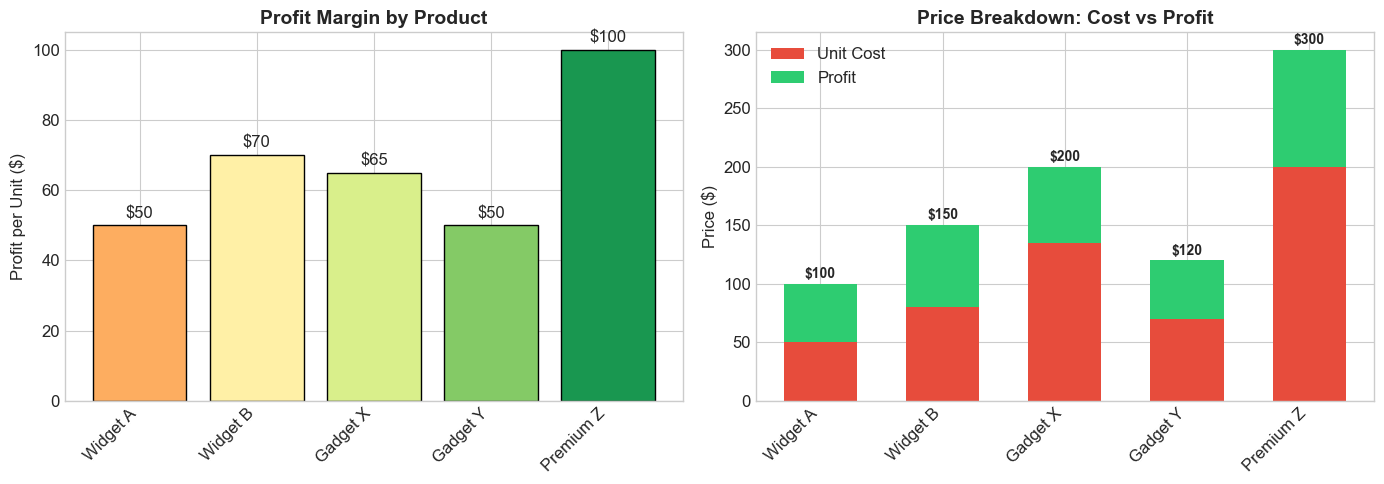

In [4]:
# Profit margin visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profit per unit
ax1 = axes[0]
profits = [p.selling_price - p.unit_cost for p in PRODUCTS]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(PRODUCTS)))
bars = ax1.bar([p.name for p in PRODUCTS], profits, color=colors, edgecolor='black')
ax1.set_ylabel('Profit per Unit ($)')
ax1.set_title('Profit Margin by Product', fontsize=14, fontweight='bold')
ax1.bar_label(bars, fmt='$%.0f', padding=3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Price breakdown stacked bar
ax2 = axes[1]
x = np.arange(len(PRODUCTS))
width = 0.6
costs = [p.unit_cost for p in PRODUCTS]
ax2.bar(x, costs, width, label='Unit Cost', color='#e74c3c')
ax2.bar(x, profits, width, bottom=costs, label='Profit', color='#2ecc71')
ax2.set_ylabel('Price ($)')
ax2.set_title('Price Breakdown: Cost vs Profit', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([p.name for p in PRODUCTS], rotation=45, ha='right')
ax2.legend()

# Add selling price labels
for i, p in enumerate(PRODUCTS):
    ax2.annotate(f'${p.selling_price:.0f}', (i, p.selling_price + 5), 
                 ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

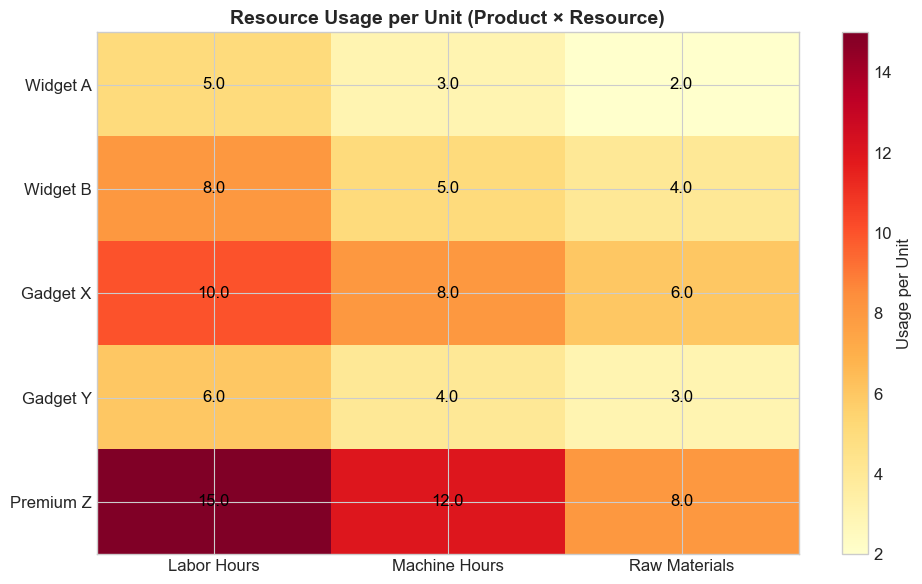

In [5]:
# Resource usage heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# Create resource usage matrix
usage_matrix = np.array([
    [get_resource_usage(p, r) for r in RESOURCES]
    for p in PRODUCTS
])

# Create heatmap
im = ax.imshow(usage_matrix, cmap='YlOrRd', aspect='auto')

# Labels
ax.set_xticks(np.arange(len(RESOURCES)))
ax.set_yticks(np.arange(len(PRODUCTS)))
ax.set_xticklabels([r.name for r in RESOURCES])
ax.set_yticklabels([p.name for p in PRODUCTS])

# Add values to cells
for i in range(len(PRODUCTS)):
    for j in range(len(RESOURCES)):
        text = ax.text(j, i, f'{usage_matrix[i, j]:.1f}',
                       ha='center', va='center', color='black', fontsize=12)

ax.set_title('Resource Usage per Unit (Product × Resource)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Usage per Unit')
plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

In [6]:
def build_production_model() -> LXModel:
    """
    Build the production planning optimization model.
    
    Uses single-model indexing where variables are indexed directly
    by Product instances, eliminating manual index management.
    """
    
    # Decision Variable: Production quantity for each product
    # KEY: LXVariable family that auto-expands to one var per product!
    production = (
        LXVariable[Product, float]("production")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda p: p.id)  # Index by product ID
        .from_data(PRODUCTS)         # Provide data directly - NO manual loops!
    )

    # Create model
    model = LXModel[Product]("production_planning").add_variable(production)

    # Objective: Maximize total profit
    # The expression automatically sums over ALL products in the variable family
    profit_expr = (
        LXLinearExpression[Product]()
        .add_term(
            production,
            coeff=lambda p: p.selling_price - p.unit_cost  # Profit per unit
        )
    )
    model.maximize(profit_expr)

    # Constraints: Resource capacity limits
    # For each resource, sum(usage * production) <= capacity
    for resource in RESOURCES:
        # Build expression that sums over all products automatically
        usage_expr = (
            LXLinearExpression()
            .add_term(
                production,
                coeff=lambda p, r=resource: get_resource_usage(p, r)
            )
        )

        # Add capacity constraint for this resource
        model.add_constraint(
            LXConstraint(f"capacity_{resource.name}")
            .expression(usage_expr)
            .le()
            .rhs(resource.capacity)
        )

    # Constraints: Minimum production requirements
    # Create constraint family indexed by Product
    model.add_constraint(
        LXConstraint[Product]("min_production")
        .expression(
            LXLinearExpression[Product]().add_term(production, 1.0)
        )
        .ge()
        .rhs(lambda p: float(p.min_production))
        .from_data(PRODUCTS)  # One constraint per product
        .indexed_by(lambda p: p.name)
    )

    return model


# Build the model
model = build_production_model()

# Display model summary
print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: production_planning
  Variable Families: 1
  Constraint Families: 4
  Objective: max



## 4. Solve the Model

In [7]:
# Create optimizer with OR-Tools solver
optimizer = LXOptimizer().use_solver("ortools")

# Solve the model
print("Solving the production planning problem...")
solution = optimizer.solve(model)

# Display solution status
print(f"\nSolution Status: {solution.status}")
print(f"Optimal Profit: ${solution.objective_value:,.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 16:52:04 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 16:52:04 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 16:52:04 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s


Solving the production planning problem...

Solution Status: optimal
Optimal Profit: $9,400.00
Solve Time: 0.000s


## 5. Analyze the Results

In [8]:
# Extract solution values
solution_data = []
total_profit = 0.0

for product in PRODUCTS:
    qty = solution.variables["production"][product.id]
    profit = (product.selling_price - product.unit_cost) * qty
    revenue = product.selling_price * qty
    cost = product.unit_cost * qty
    total_profit += profit
    
    solution_data.append({
        'Product': product.name,
        'Quantity': qty,
        'Min Required': product.min_production,
        'Revenue ($)': revenue,
        'Cost ($)': cost,
        'Profit ($)': profit,
        'Profit/Unit ($)': product.selling_price - product.unit_cost
    })

# Create solution DataFrame
solution_df = pd.DataFrame(solution_data)

# Display production plan
print("\n" + "=" * 70)
print("OPTIMAL PRODUCTION PLAN")
print("=" * 70)
display(solution_df.round(2).set_index('Product'))

print(f"\nTotal Profit: ${total_profit:,.2f}")


OPTIMAL PRODUCTION PLAN


,Quantity,Min Required,Revenue ($),Cost ($),Profit ($),Profit/Unit ($)
Product,,,,,,
Widget A,152.6,10,15260.0,7630.0,7630.0,50.0
Widget B,5.0,5,750.0,400.0,350.0,70.0
Gadget X,8.0,8,1600.0,1080.0,520.0,65.0
Gadget Y,12.0,12,1440.0,840.0,600.0,50.0
Premium Z,3.0,3,900.0,600.0,300.0,100.0



Total Profit: $9,400.00


In [9]:
# Calculate resource utilization
resource_data = []

for resource in RESOURCES:
    used = sum(
        solution.variables["production"][p.id] * get_resource_usage(p, resource)
        for p in PRODUCTS
    )
    resource_data.append({
        'Resource': resource.name,
        'Used': used,
        'Capacity': resource.capacity,
        'Utilization (%)': (used / resource.capacity) * 100,
        'Slack': resource.capacity - used
    })

resource_df = pd.DataFrame(resource_data)

print("\n" + "=" * 70)
print("RESOURCE UTILIZATION")
print("=" * 70)
display(resource_df.round(2).set_index('Resource'))


RESOURCE UTILIZATION


,Used,Capacity,Utilization (%),Slack
Resource,,,,
Labor Hours,1000.0,1000.0,100.00,0.0
Machine Hours,630.8,800.0,78.85,169.2
Raw Materials,433.2,500.0,86.64,66.8


## 6. Visualize the Optimal Solution

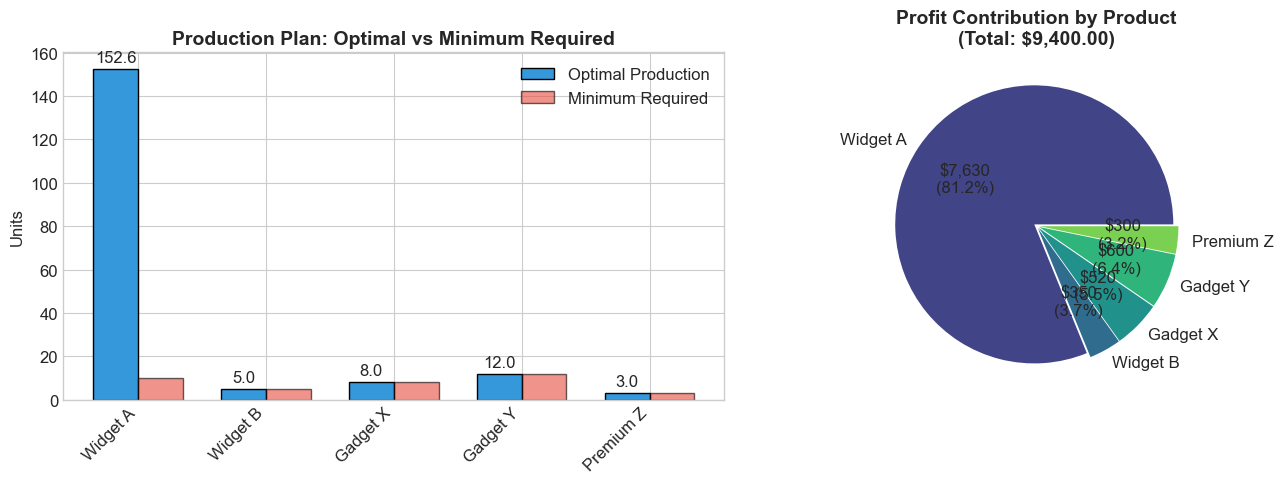

In [10]:
# Production quantities bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Production quantities
ax1 = axes[0]
x = np.arange(len(PRODUCTS))
width = 0.35

quantities = solution_df['Quantity'].values
min_required = solution_df['Min Required'].values

bars1 = ax1.bar(x - width/2, quantities, width, label='Optimal Production', color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, min_required, width, label='Minimum Required', color='#e74c3c', alpha=0.6, edgecolor='black')

ax1.set_ylabel('Units')
ax1.set_title('Production Plan: Optimal vs Minimum Required', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(solution_df['Product'], rotation=45, ha='right')
ax1.legend()
ax1.bar_label(bars1, fmt='%.1f', padding=3)

# Profit contribution
ax2 = axes[1]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(PRODUCTS)))
profits = solution_df['Profit ($)'].values

wedges, texts, autotexts = ax2.pie(
    profits, 
    labels=solution_df['Product'],
    autopct=lambda pct: f'${pct/100*total_profit:,.0f}\n({pct:.1f}%)',
    colors=colors,
    explode=[0.02]*len(PRODUCTS)
)
ax2.set_title(f'Profit Contribution by Product\n(Total: ${total_profit:,.2f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

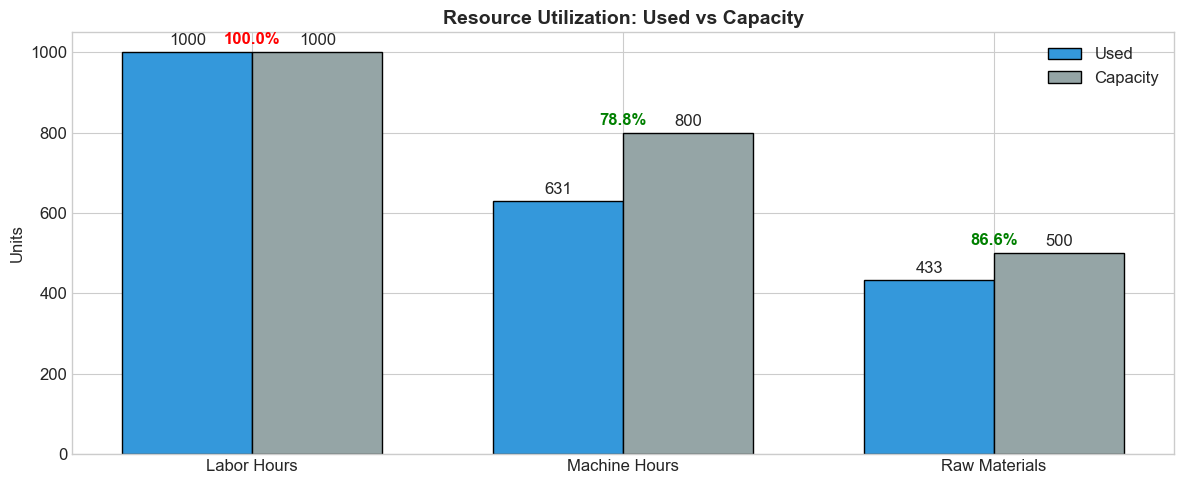

In [11]:
# Resource utilization visualization
fig, ax = plt.subplots(figsize=(12, 5))

resources_names = resource_df['Resource'].values
used = resource_df['Used'].values
capacity = resource_df['Capacity'].values
utilization = resource_df['Utilization (%)'].values

x = np.arange(len(resources_names))
width = 0.35

# Used vs Capacity bars
bars1 = ax.bar(x - width/2, used, width, label='Used', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, capacity, width, label='Capacity', color='#95a5a6', edgecolor='black')

ax.set_ylabel('Units')
ax.set_title('Resource Utilization: Used vs Capacity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(resources_names)
ax.legend()

# Add utilization percentage labels
for i, (u, c, pct) in enumerate(zip(used, capacity, utilization)):
    ax.annotate(f'{pct:.1f}%', (i, max(u, c) + 20), ha='center', fontsize=12, fontweight='bold',
                color='green' if pct < 90 else 'red')

ax.bar_label(bars1, fmt='%.0f', padding=3)
ax.bar_label(bars2, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()

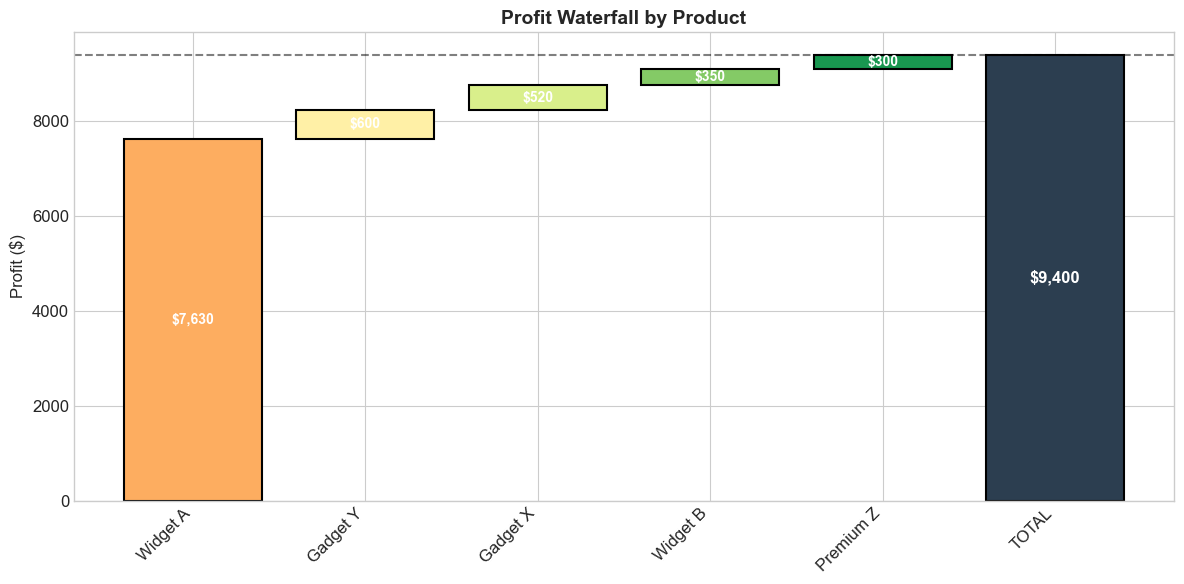

In [12]:
# Profit waterfall chart
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for waterfall
products_sorted = solution_df.sort_values('Profit ($)', ascending=False)
profits_sorted = products_sorted['Profit ($)'].values
names_sorted = products_sorted['Product'].values

# Calculate cumulative values
cumulative = np.cumsum(profits_sorted)
bottom = np.concatenate([[0], cumulative[:-1]])

# Colors based on profit contribution
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(profits_sorted)))

# Create waterfall bars
bars = ax.bar(range(len(names_sorted)), profits_sorted, bottom=bottom, 
              color=colors, edgecolor='black', linewidth=1.5)

# Add total bar
ax.bar(len(names_sorted), total_profit, color='#2c3e50', edgecolor='black', linewidth=1.5)

# Styling
ax.set_ylabel('Profit ($)')
ax.set_title('Profit Waterfall by Product', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(names_sorted) + 1))
ax.set_xticklabels(list(names_sorted) + ['TOTAL'], rotation=45, ha='right')

# Add value labels
for i, (b, p) in enumerate(zip(bottom, profits_sorted)):
    ax.annotate(f'${p:,.0f}', (i, b + p/2), ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')

ax.annotate(f'${total_profit:,.0f}', (len(names_sorted), total_profit/2), 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Add horizontal line at total
ax.axhline(y=total_profit, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

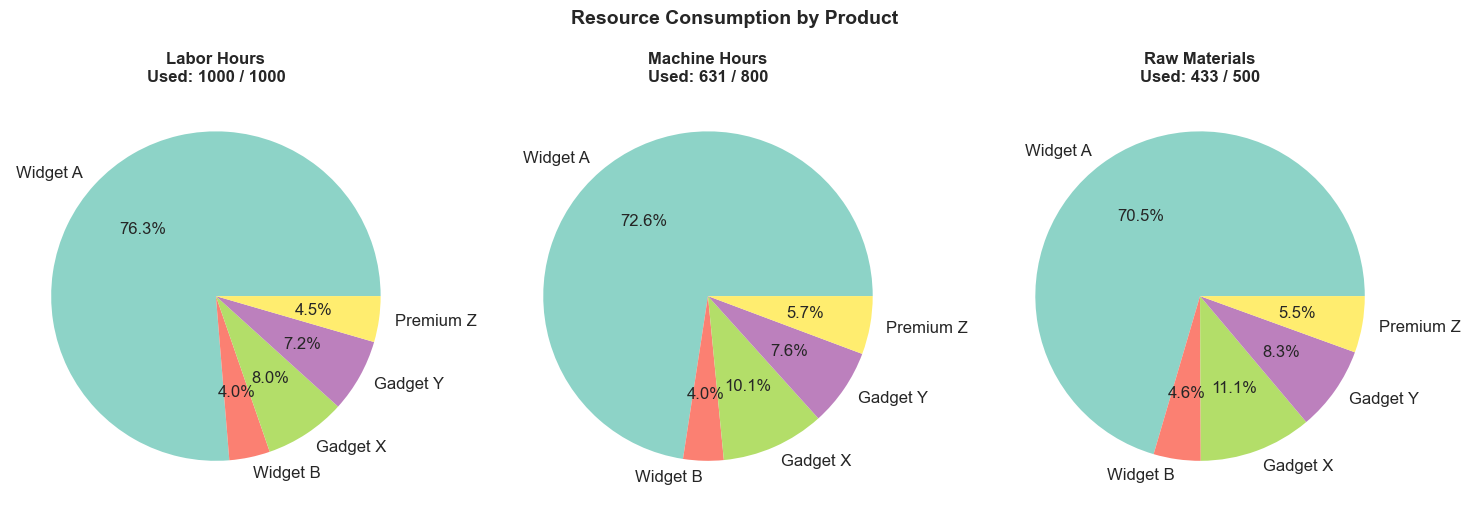

In [13]:
# Resource consumption breakdown by product
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, resource in zip(axes, RESOURCES):
    # Calculate each product's consumption of this resource
    consumptions = []
    labels = []
    for p in PRODUCTS:
        qty = solution.variables["production"][p.id]
        consumption = qty * get_resource_usage(p, resource)
        if consumption > 0.01:
            consumptions.append(consumption)
            labels.append(p.name)
    
    if consumptions:
        colors = plt.cm.Set3(np.linspace(0, 1, len(consumptions)))
        ax.pie(consumptions, labels=labels, autopct='%.1f%%', colors=colors)
        
        total_used = sum(consumptions)
        ax.set_title(f'{resource.name}\nUsed: {total_used:.0f} / {resource.capacity:.0f}', 
                     fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No usage', ha='center', va='center')
        ax.set_title(resource.name)

plt.suptitle('Resource Consumption by Product', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Key Insights

### What We Learned

1. **Single-Model Indexing**: Variables are indexed by `Product` instances using `indexed_by(lambda p: p.id)`. This eliminates manual index management and makes the code more readable.

2. **Constraint Families**: The minimum production constraint is created as a family that automatically expands to one constraint per product using `.from_data(PRODUCTS)`.

3. **Data-Driven Coefficients**: Profit coefficients are extracted directly from product attributes using `lambda p: p.selling_price - p.unit_cost`.

4. **Resource Constraints**: Each resource has its own capacity constraint, summing usage across all products.

### Business Insights

Looking at the solution:
- Products with highest profit margins get prioritized
- Minimum production requirements are satisfied
- Resource utilization shows which constraints are binding
- The profit waterfall shows each product's contribution

## 8. Extensions & Exercises

Try modifying this notebook to explore:

1. **Add a new product**: What happens if you add a highly profitable but resource-intensive product?

2. **Increase resource capacity**: How does adding 100 more labor hours affect optimal profit?

3. **Add demand limits**: Limit maximum production for each product (market demand constraints)

4. **Multi-period planning**: Extend the model to plan production over multiple weeks

5. **Integer variables**: Change to integer production (can't produce 0.5 units)

In [ ]:
# Exercise hint: Adding integer variables
# Change the variable definition:
# production = (
#     LXVariable[Product, int]("production")  # <-- Change type hint
#     .integer()                               # <-- Change to integer
#     .bounds(lower=0)
#     .indexed_by(lambda p: p.id)
#     .from_data(PRODUCTS)
# )